**In this project, you need to program a bot that automatically trades stocks for you. The bot
should use sophisticated machine learning algorithms to predict future stock prices and then
decide to buy or sell the stock. You should test the performance of the bot empirically over a
certain time frame and for different stocks.**


#### Data
You can collect your own stock price data for which you want to train the algorithms.
The example data set are daily stock prices of Apple from January to the end of March 2021.
You can use the same set and/or another of your choosing.

#### Tasks
• Choose a stock/index/currency/commodity/etc. and collect price data for a certain time
frame that you want to use to train and test the algorithms. To train these algorithms
you should have a sufficient amount of data points. Daily returns are easily accessible
but you can also try to look at intra-day data and go the high-frequency trading route.

• As a benchmark, come up with some easy rules to buy and sell the stock (i.e. buy the
stock if it was down the day before, ...). Also implement an algorithm that buys the stock
at random. Test the performance of the strategies empirically.

• Now use more sophisticated approaches to predict the future stock price and let the
trading bot invest based on these forecasts. This is a typical time series application. Check
if the assumptions of the models hold. Find the best time series model and implement it
into the trading bot. Show the performance.

• Try to use other machine learning algorithms to predict stock prices and compare their
performance.

• Your trading bot should work well for your stock and time frame now. What about
another time frame? Or another stock/index?

• It probably won’t perform as well as it did before and you would need to adjust the
algorithm’s parameters or change it altogether. It requires a lot of time to do that
manually every time. Write a program that automatically finds the best approach for
any given asset and time frame to optimize your trading bot.

#### Possible Extensions:
• Assume that your trading bot can also sell short instead of just buying assets.
• In a real setting, you would also need to consider trading fees and probably also taxes.
What would change? How can you take this into account when optimizing your bot?

## 1. Import Libraries and Data Preprocessing

In [97]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
%matplotlib inline
from datetime import timedelta
from pandas.plotting import autocorrelation_plot
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import random




import warnings
warnings.filterwarnings("ignore")

In [98]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = actual[j] - predicted[j]
        else:
            rej[j] = predicted[j]
            
    return res

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/ y_true))*100

def weighted_mean_absolute_percentage_error(y_true, y_pred):
    if sum(y_true) == 0:
        denominator = 1
    else:
        denominator = sum(y_true)
    return (sum(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))))*100/denominator
    

In [99]:
apple = pd.read_csv("AAPL_returns.csv")

## To calculate the return, we already have returns in the dataset
#apple['stock_return'] = ( apple['Adj Close'] - apple['Adj Close'].shift(1) )/(apple['Adj Close'].shift(1))
apple = apple.dropna()
apple.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close,returns
0,2021-01-04,133.610001,126.760002,133.520004,129.410004,143301900.0,127.874939,-0.024719
1,2021-01-05,131.740005,128.429993,128.889999,131.009995,97664900.0,129.455963,0.012364
2,2021-01-06,131.050003,126.379997,127.720001,126.599998,155088000.0,125.098267,-0.033662


In [100]:
apple.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       62 non-null     object 
 1   High       62 non-null     float64
 2   Low        62 non-null     float64
 3   Open       62 non-null     float64
 4   Close      62 non-null     float64
 5   Volume     62 non-null     float64
 6   Adj Close  62 non-null     float64
 7   returns    62 non-null     float64
dtypes: float64(7), object(1)
memory usage: 4.0+ KB


In [101]:
apple.describe()

,High,Low,Open,Close,Volume,Adj Close,returns
count,62.000000,62.000000,62.000000,62.000000,6.200000e+01,62.000000,62.000000
mean,129.977904,126.597742,128.532581,128.271613,1.096714e+08,126.866392,-0.000987
std,6.696031,6.500335,6.705765,6.738133,2.964228e+07,6.610091,0.020753
min,120.400002,116.209999,119.029999,116.360001,6.014510e+07,115.151558,-0.041673
25%,123.902502,120.587502,122.647497,121.984999,8.894782e+07,120.718130,-0.014778
50%,129.860001,126.810001,128.385002,127.810001,1.034714e+08,126.388264,-0.001658
75%,135.710003,132.324993,134.212505,133.752502,1.196941e+08,132.215115,0.011957
max,145.089996,141.369995,143.600006,143.160004,1.855495e+08,141.461838,0.053851


In [102]:
# Convert date to DateTime format
apple['Date'] = pd.to_datetime(apple['Date'])
apple.head()

,Date,High,Low,Open,Close,Volume,Adj Close,returns
0,2021-01-04,133.610001,126.760002,133.520004,129.410004,143301900.0,127.874939,-0.024719
1,2021-01-05,131.740005,128.429993,128.889999,131.009995,97664900.0,129.455963,0.012364
2,2021-01-06,131.050003,126.379997,127.720001,126.599998,155088000.0,125.098267,-0.033662
3,2021-01-07,131.630005,127.860001,128.360001,130.919998,109578200.0,129.367035,0.034123
4,2021-01-08,132.630005,130.229996,132.429993,132.050003,105158200.0,130.483627,0.008631


## 1.1 Visualization of Adj Close and Returns values - Trend and Seasonality

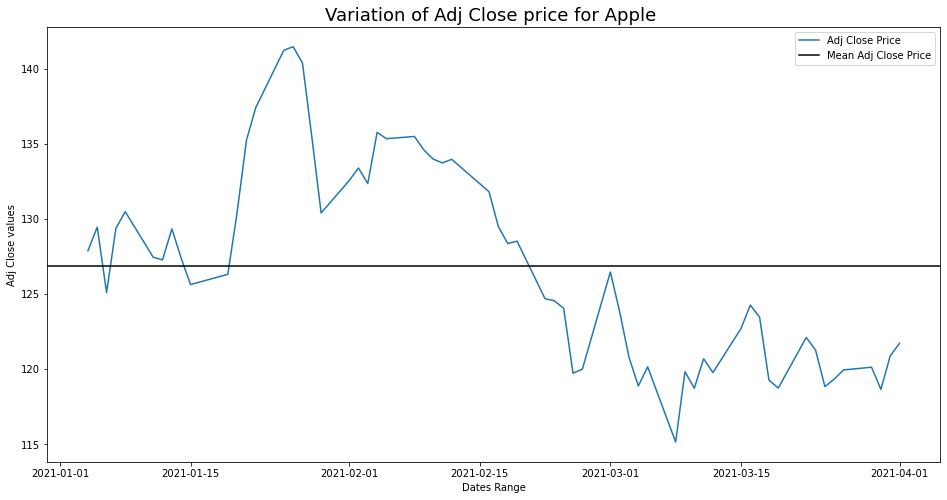

In [103]:
fig, ax = plt.subplots(1,1, figsize = (16,8))
sns.lineplot(x='Date', y='Adj Close', data=apple, ax=ax)
ax.axhline(apple['Adj Close'].mean(), color='k')
ax.set_xlabel('Dates Range')
ax.set_ylabel('Adj Close values')
ax.set_title("Variation of Adj Close price for Apple ", fontsize = 18)
plt.legend(('Adj Close Price','Mean Adj Close Price'));

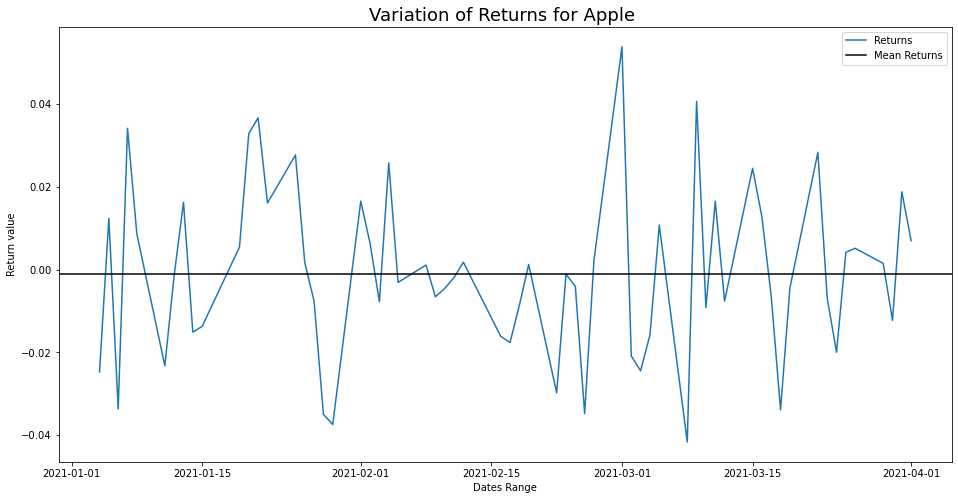

In [104]:
fig, ax = plt.subplots(1,1, figsize = (16,8))
sns.lineplot(x='Date', y='returns', data=apple, ax=ax)
ax.axhline(apple['returns'].mean(), color='k')
ax.set_xlabel('Dates Range')
ax.set_ylabel('Return value')
ax.set_title("Variation of Returns for Apple ", fontsize = 18)
plt.legend(('Returns','Mean Returns'));

* In comparision to Adj Close price, return is quite flactuating and 
* Trends and seasonality is not visible from the graph for returns

In [105]:
# Testing For Stationarity

#Null Hypothesis H0 = If failed to be rejected, it suggests the time series has a unit root, 
#                     meaning it is non-stationary

#Alternative Hypothesis H1 = The null hypothesis is rejected and suggests the time series 
#                            does not have a unit root, meaning it is stationary

def adfuller_test(returns):
    result=adfuller(returns)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

adfuller_test(apple['returns'])

ADF Test Statistic : -8.139094784238278
p-value : 1.039806444152943e-12
#Lags Used : 0
Number of Observations Used : 61
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


We get the strong evidence that our data is stationary, which indicate its mean and variance are not varying with time and we can use tradition time series algorithm for forecasting.

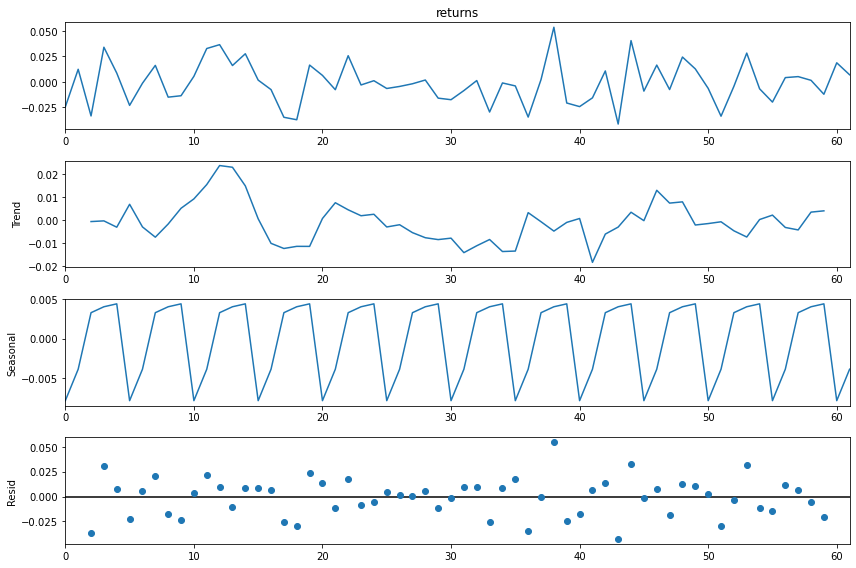

In [106]:
plt.rcParams['figure.figsize'] = (12, 8)
result = seasonal_decompose(apple['returns'], model='additive', period=5)
result.plot()
plt.show();


There seems to some seasonality in data which repeat every few days (5 in this case)

## 1.2 Autocorrelation and Partial Autocorrelation

### Autocorrelation and Partial Autocorrelation

* Identification of an AR model is often best done with the PACF.
    * For an AR model, the theoretical PACF “shuts off” past the order of the model.  The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point.  Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.  By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
    
    
* Identification of an MA model is often best done with the ACF rather than the PACF.
    * For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.
    
    p,d,q
    p AR model lags
    d differencing
    q MA lags

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

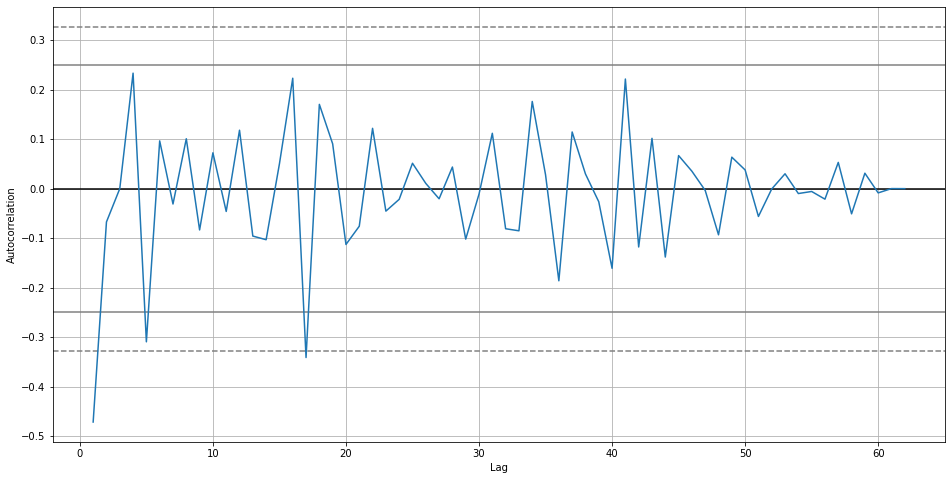

In [107]:
fig, ax = plt.subplots(1,1, figsize = (16,8))
autocorrelation_plot(apple['returns'].diff().fillna(0), ax=ax)

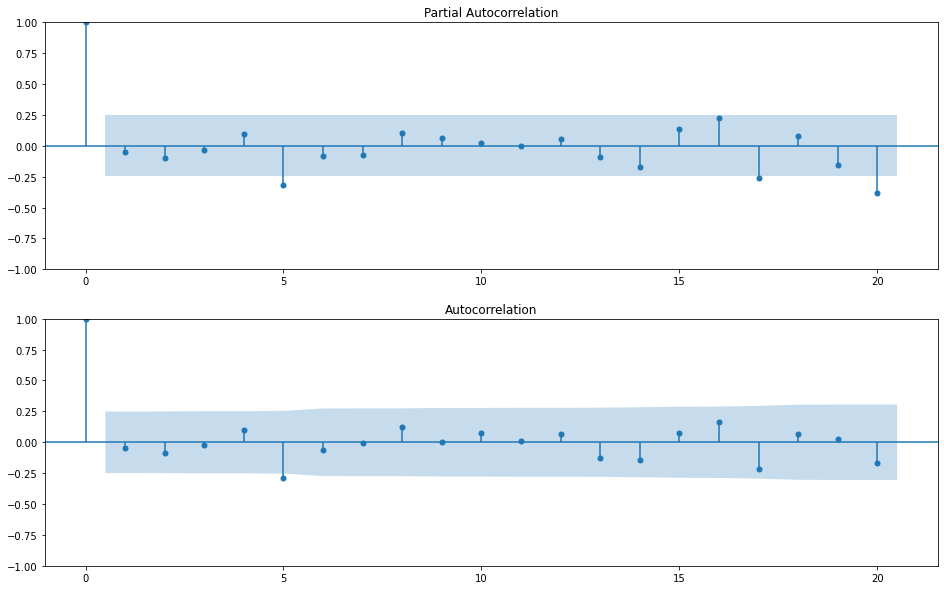

In [108]:
fig, ax = plt.subplots(2,1, figsize = (16,10))
pacf = plot_pacf(apple['returns'].dropna(),lags=20, ax=ax[0])
acf = plot_acf(apple['returns'].dropna(),lags=20, ax=ax[1])

There are Partial Autocorrelation, We explore lags till AR= 5 lags, amd MA=5 lags.

## 2. Time-Series Model
### 2.1 Basic ARIMA model

In [109]:
## Set date as index and seperate the data for train and test
apple = apple.set_index('Date')
apple.head()

,High,Low,Open,Close,Volume,Adj Close,returns
Date,,,,,,,
2021-01-04,133.610001,126.760002,133.520004,129.410004,143301900.0,127.874939,-0.024719
2021-01-05,131.740005,128.429993,128.889999,131.009995,97664900.0,129.455963,0.012364
2021-01-06,131.050003,126.379997,127.720001,126.599998,155088000.0,125.098267,-0.033662
2021-01-07,131.630005,127.860001,128.360001,130.919998,109578200.0,129.367035,0.034123
2021-01-08,132.630005,130.229996,132.429993,132.050003,105158200.0,130.483627,0.008631


In [110]:
train_end = datetime(2021, 3, 15)
test_end = datetime(2021, 4, 1)

train_data = apple[:train_end]
test_data = apple[train_end+timedelta(days = 1):test_end]

In [111]:
## ARIMA Basic Model
train = train_data['returns']
test = test_data['returns']
arima_model = ARIMA(train, order=(1,0,1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                   49
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 119.161
Date:                Wed, 08 Feb 2023   AIC                           -230.322
Time:                        20:13:11   BIC                           -222.754
Sample:                             0   HQIC                          -227.451
                                 - 49                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.001     -1.087      0.277      -0.004       0.001
ar.L1          0.8815      0.174      5.056      0.000       0.540       1.223
ma.L1         -0.9997     16.379     -0.061      0.951     -33.103      31.103
sigma2         0.0004      0.007      0.062      0.951      -0.014       0.014
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.55
Prob(Q):                              0.91   Prob(JB):                         0.76
Heteroskedasticity (H):               1.18   Skew:                             0.13
Prob(H) (two-sided):                  0.75   Kurtosis:                         2.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Rolling Forecast using basic ARIMA model

Mean Absolute Percent Error(MAPE) 128.11983472231378
Root Mean Squared Error(RMSE) 0.015747064483425652
Weighted Mean Absolute Percentage Error (WMAPE) -2626.741644657645


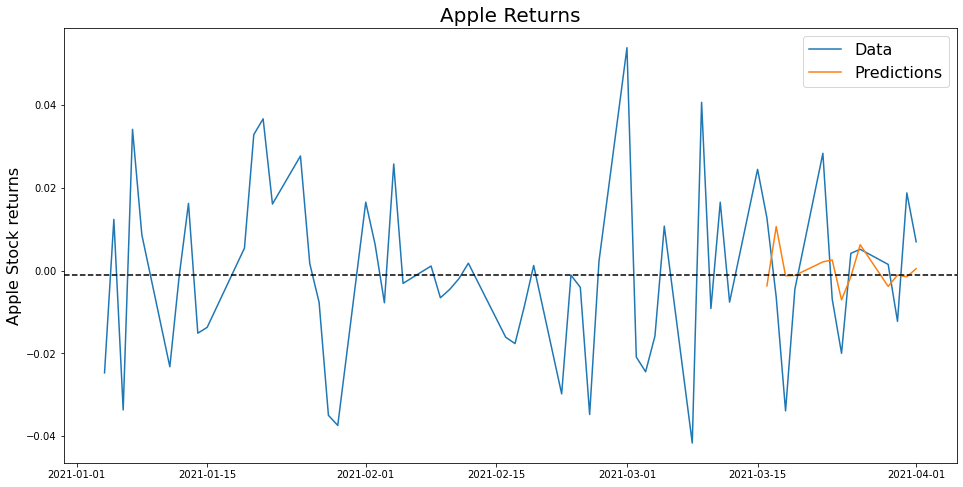

In [112]:
# rolling forecast taking into account actual data to predict next days

rolling_pred_arima = test_data.copy()
#rolling_predictions['rolling_forecast'] = test['returns']

for train_end in test_data.index:
    rolling_train_data = apple[:train_end - timedelta(days=1)]
    model=ARIMA(rolling_train_data['returns'],order=(1,0,3))
    model_fit = model.fit()
    
    pred = model_fit.forecast()
    rolling_pred_arima.loc[train_end,'rolling_forecast'] = pred.item()
    #rolling_predictions[train_end] = pred
    
fig, ax = plt.subplots(1,1, figsize = (16,8))

plt.plot(apple['returns'])
plt.plot(rolling_pred_arima['rolling_forecast'])
ax.axhline(apple['returns'].mean(), linestyle = '--', color = 'k')

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Apple Returns', fontsize=20)
plt.ylabel('Apple Stock returns', fontsize=16);

print("Mean Absolute Percent Error(MAPE) {}".format(mean_absolute_percentage_error(
    rolling_pred_arima['returns'], rolling_pred_arima['rolling_forecast'])))

print("Root Mean Squared Error(RMSE) {}".format(np.sqrt(mean_squared_error(
    rolling_pred_arima['returns'], rolling_pred_arima['rolling_forecast']))))

print("Weighted Mean Absolute Percentage Error (WMAPE) {}".format(weighted_mean_absolute_percentage_error(
    rolling_pred_arima['returns'], rolling_pred_arima['rolling_forecast'])))


ARIMA model predictions are poor and it failed to predict the changing patterns, its output is average of returns.
We need to include seasonality as well and try different models

## 2.2 SARIMA model

Mean Absolute Percent Error(MAPE) 163.90609944636768
Root Mean Squared Error(RMSE) 0.01876518315790013
Weighted Mean Absolute Percentage Error (WMAPE) -3036.125557425298


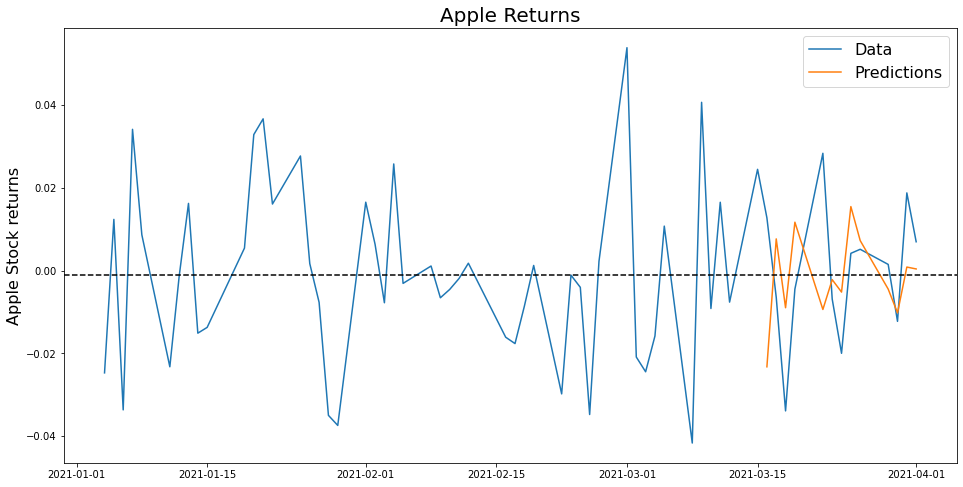

In [113]:
# rolling forecast taking into account actual data to predict next days

rolling_pred_sarima = test_data.copy()

for train_end in test_data.index:
    rolling_train_data = apple[:train_end - timedelta(days=1)]
    model=SARIMAX(rolling_train_data['returns'], order=(5, 0, 3), seasonal_order=(0, 0, 0, 5))
    model_fit = model.fit(disp = 0)
    
    pred = model_fit.forecast()
    rolling_pred_sarima.loc[train_end,'rolling_forecast'] = pred.item()
    
fig, ax = plt.subplots(1,1, figsize = (16,8))

plt.plot(apple['returns'])
plt.plot(rolling_pred_sarima['rolling_forecast'])
ax.axhline(apple['returns'].mean(), linestyle = '--', color = 'k')

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Apple Returns', fontsize=20)
plt.ylabel('Apple Stock returns', fontsize=16);

print("Mean Absolute Percent Error(MAPE) {}".format(mean_absolute_percentage_error(
    rolling_pred_sarima['returns'], rolling_pred_sarima['rolling_forecast'])))

print("Root Mean Squared Error(RMSE) {}".format(np.sqrt(mean_squared_error(
    rolling_pred_sarima['returns'], rolling_pred_sarima['rolling_forecast']))))

print("Weighted Mean Absolute Percentage Error (WMAPE) {}".format(weighted_mean_absolute_percentage_error(
    rolling_pred_sarima['returns'], rolling_pred_sarima['rolling_forecast'])))



## Making future forecast and Implement Buy and Sell Rule



## 1. Random Trading 

We will test our rule and a random rule for testing period, 
rule1(baisc): based on model forecast:
##### if return is negative sell and if return is positive buy
we will start will the capacity of 500 worth of stock money

Random rule: randomly decide to buy and sell based (1 - buy, 2-sell)

In [114]:
### Random Trading Rules
# 0: Do Nothing
# 1: Buy and then sell same day

def random_trading(data):
    money = 100 ## Euro to buy the stocks
    
    for i in range(len(data)-1):
        trading = random.randint(0, 1)

        if trading == 1:
            data.loc[i, 'trading_random'] = 100
        else:
            data.loc[i, 'trading_random'] = 0
            
    data['trading_random'] = data['trading_random'].fillna(0)       
    data['trading_random'] = data['trading_random'].astype(int)
    return data

### simple rule to buy-sell or do nothing based on forecasted returns
# 1: Buy - Sell stocks worth 100 euro on same day based on if return is positive
# 2: Do nothing -  if return is less rthan zero

def bot_trading(data):
    money = 100 ## worth of stocks which we can buy
    
    for i in range(len(data)-1):
        
        if data.loc[i, 'rolling_forecast'] > 0:
            data.loc[i, 'trading_bot'] = 100
        else:
            data.loc[i, 'trading_bot'] = 0 # do nothing 
            
    data['trading_bot'] = data['trading_bot'].fillna(0)       
    data['trading_bot'] = data['trading_bot'].astype(int)
    return data

def optimum_trading(data):
    money = 100 ## worth of stocks which we can buy
    
    for i in range(len(data)-1):
        
        if data.loc[i, 'returns'] > 0:
            data.loc[i, 'trading_optimum'] = 100
        else:
            data.loc[i, 'trading_optimum'] = 0 # do nothing 
            
    data['trading_optimum'] = data['trading_optimum'].fillna(0)       
    data['trading_optimum'] = data['trading_optimum'].astype(int)
    return data


def stock_returns_calculation(data, trading_rule):
    stock_returns = 0
    for i in range(len(data)):
        stock_returns += data.loc[i, 'returns'] * data.loc[i, trading_rule]
        
    return stock_returns

def average_random_trading(df_random, trading_rule):
    total_random_returns = 0
    trial = 100
    for i in range(trial):
        df_random_trading = random_trading(df_random)
        random_returns = stock_returns_calculation(df_random_trading, trading_rule)
        total_random_returns += random_returns

    return total_random_returns / trial


In [115]:
forecast_arima = rolling_pred_arima.copy(deep=True)
forecast_arima = forecast_arima.reset_index()

random_rule = 'trading_random'
trading_bot_simple = 'trading_bot'
trading_optimum = 'trading_optimum'

print(f'Average Returns in trading period using Random Trading: {average_random_trading(forecast_arima, random_rule)}')
print(f'Returns in trading period using trading rule: {stock_returns_calculation(bot_trading(forecast_arima), trading_bot_simple)}')
print(f'Optimum Returns in trading period using trading rule: {stock_returns_calculation(optimum_trading(forecast_arima), trading_optimum)}')


Average Returns in trading period using Random Trading: -0.9643410897921523
Returns in trading period using trading rule: 2.0138122639163103
Optimum Returns in trading period using trading rule: 7.063426747563


In [116]:
forecast_sarima = rolling_pred_sarima.copy(deep=True)
forecast_sarima = forecast_sarima.reset_index()

random_rule = 'trading_random'
trading_bot_simple = 'trading_bot'
trading_optimum = 'trading_optimum'

print(f'Average Returns in trading period using Random Trading: {average_random_trading(forecast_sarima, random_rule)}')
print(f'Returns in trading period using trading rule: {stock_returns_calculation(bot_trading(forecast_sarima), trading_bot_simple)}')
print(f'Optimum Returns in trading period using trading rule: {stock_returns_calculation(optimum_trading(forecast_sarima), trading_optimum)}')



Average Returns in trading period using Random Trading: -0.8160640038055036
Returns in trading period using trading rule: 1.7140229409619199
Optimum Returns in trading period using trading rule: 7.063426747563


In [117]:
forecast

,Date,High,Low,Open,Close,Volume,Adj Close,returns,rolling_forecast,trading_random,trading_bot,trading_optimum
0,2021-03-16,127.220001,124.720001,125.699997,125.570000,115227900.0,124.265900,0.012743,-0.011673,100,0,100
1,2021-03-17,125.860001,122.339996,124.050003,124.760002,111932600.0,123.464333,-0.006450,-0.015758,100,0,0
2,2021-03-18,123.180000,120.320000,122.879997,120.529999,121229700.0,119.278244,-0.033905,-0.024650,100,0,0
3,2021-03-19,121.430000,119.680000,119.900002,119.989998,185549500.0,118.743858,-0.004480,0.007180,0,100,0
4,2021-03-22,123.870003,120.260002,120.330002,123.389999,111912300.0,122.108551,0.028336,0.006417,100,100,100
5,2021-03-23,124.239998,122.139999,123.330002,122.540001,95467100.0,121.267372,-0.006889,0.010639,100,100,0
6,2021-03-24,122.900002,120.070000,122.820000,120.089996,88530500.0,118.842812,-0.019994,-0.017472,100,0,0
7,2021-03-25,121.660004,119.000000,119.540001,120.589996,98844700.0,119.337616,0.004164,0.003086,0,100,100
8,2021-03-26,121.480003,118.919998,120.349998,121.209999,94071200.0,119.951202,0.005142,0.001793,100,100,100
9,2021-03-29,122.580002,120.730003,121.650002,121.389999,80819200.0,120.129311,0.001485,-0.016949,100,0,100
